<a href="https://colab.research.google.com/github/amimulhasan/ML_project/blob/main/92_acc_brain_tumor_mri_classification_EfficientNetB1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook objectives
- Use Xception to classify brain tumors

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tombackert/brain-tumor-mri-data

Dataset URL: https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data
License(s): MIT
brain-tumor-mri-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

zip_path = '/content/brain-tumor-mri-data.zip'
extract_to = 'Tumor_brain_cancer'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
### Imports

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import SGD
#---------------------------------------


import warnings
warnings.filterwarnings("ignore")


# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

# Explanatory Data Analysis (EDA)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not founde')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_df(path):
    classes, class_paths = zip(*[(label, os.path.join(path, label, image))
                                 for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                 for image in os.listdir(os.path.join(path, label))])

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [ ]:
df = load_df('/content/Tumor_brain_cancer/brain-tumor-mri-dataset')

In [ ]:
df

,Class Path,Class
0,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
1,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
2,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
3,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
4,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
...,...,...
7148,/content/Tumor_brain_cancer/brain-tumor-mri-da...,pituitary
7149,/content/Tumor_brain_cancer/brain-tumor-mri-da...,pituitary
7150,/content/Tumor_brain_cancer/brain-tumor-mri-da...,pituitary
7151,/content/Tumor_brain_cancer/brain-tumor-mri-da...,pituitary


In [ ]:
### Function for counting images in each class
def count_images(df):
  plt.figure(figsize=(15,7))
  ax = sns.countplot(data=df, y=df['Class'], palette='rocket')

  plt.xlabel('')
  plt.ylabel('')
  plt.title('Count of images in each class')
  ax.bar_label(ax.containers[0])
  plt.show()

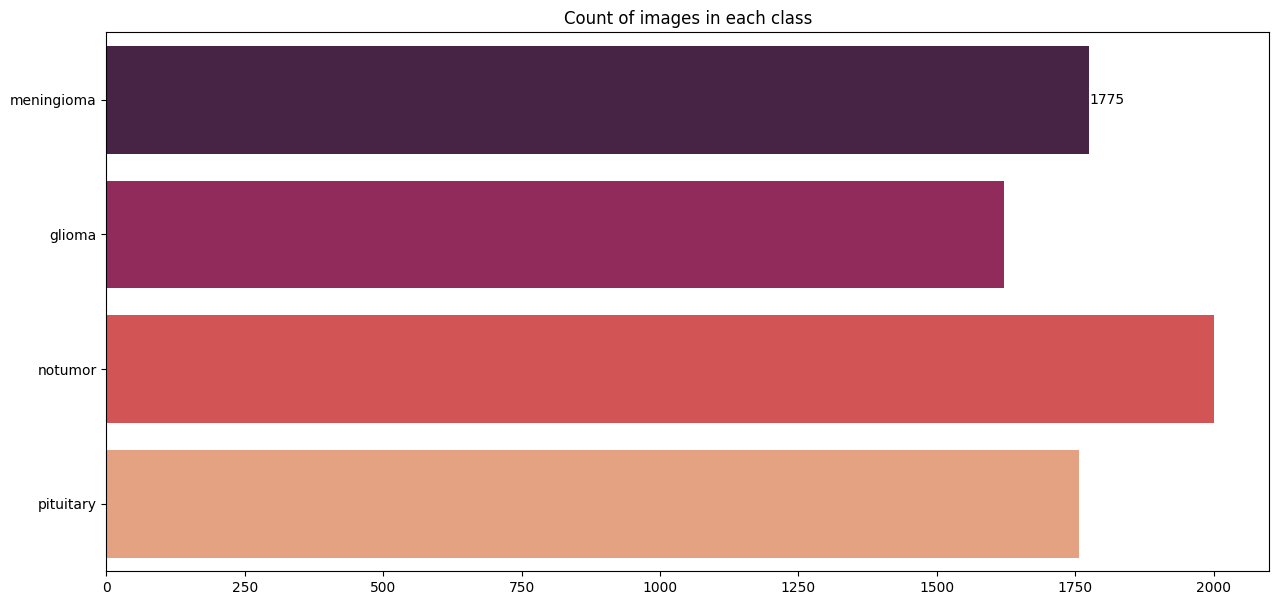

In [ ]:
count_images(df)

In [ ]:
# Train: 81.7%, Validation: 9.1%, Test: 9.2%

train_df, test_val_df = train_test_split(df, train_size=5842 / 7153, random_state=42, stratify=df['Class'])

valid_df, test_df = train_test_split(test_val_df, train_size=655 / len(test_val_df), random_state=20, stratify=test_val_df['Class'])

print(f"Train size: {len(train_df)} rows")
print(f"Validation size: {len(valid_df)} rows")
print(f"Test size: {len(test_df)} rows")

Train size: 5842 rows
Validation size: 655 rows
Test size: 656 rows


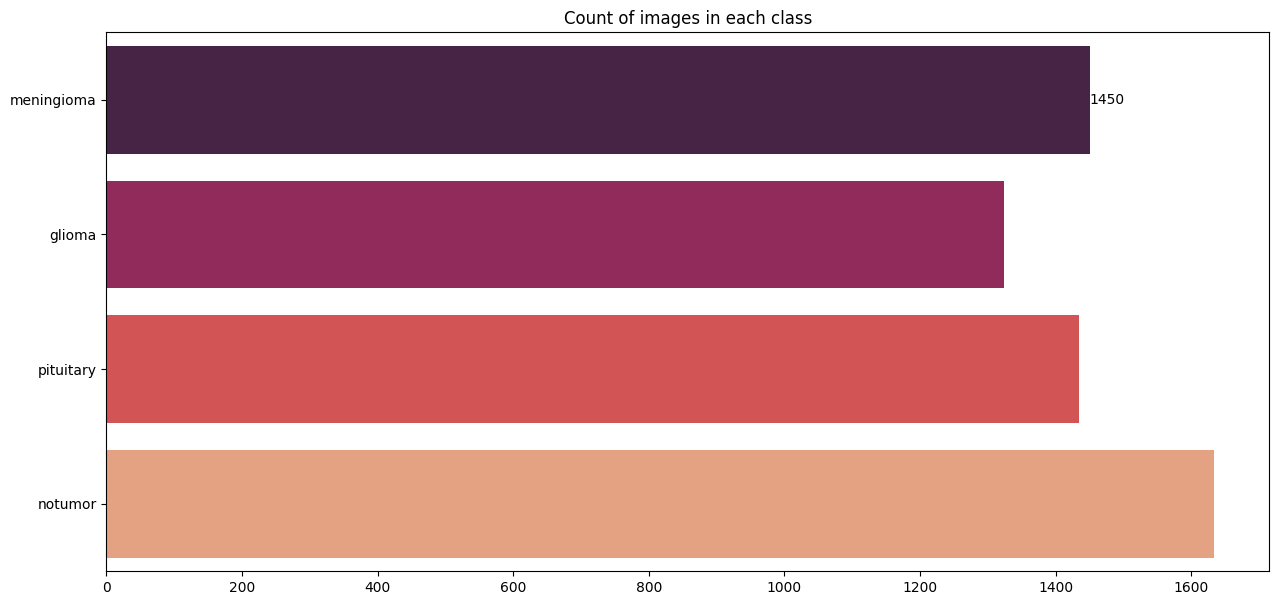

In [ ]:
count_images(train_df)

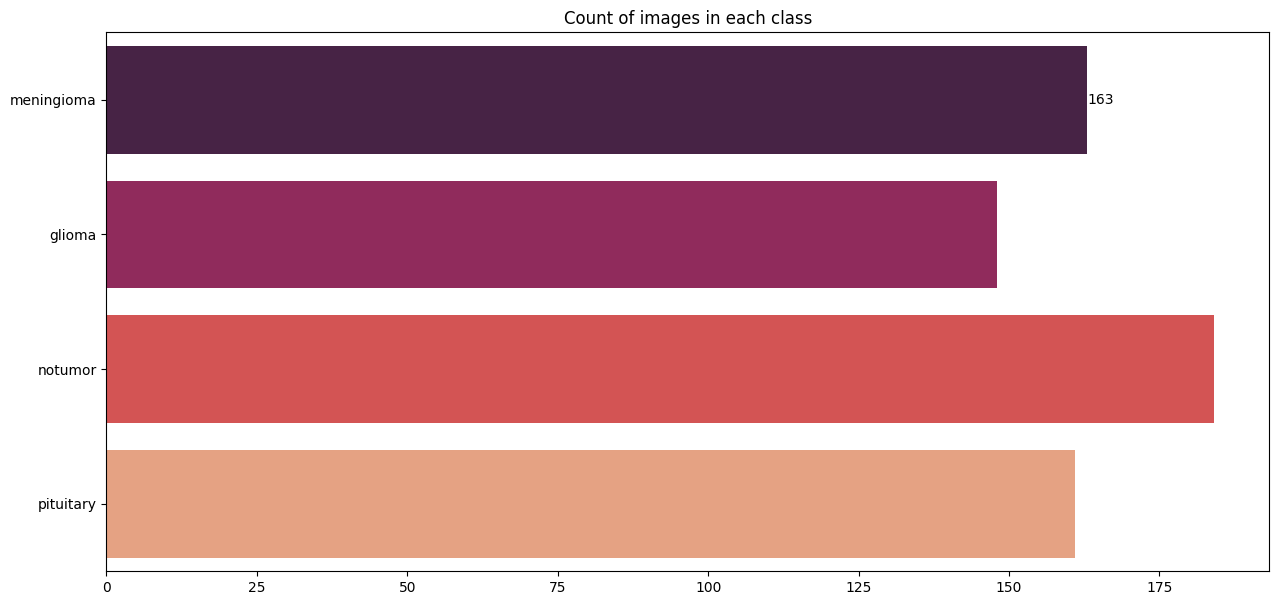

In [ ]:
count_images(test_df)

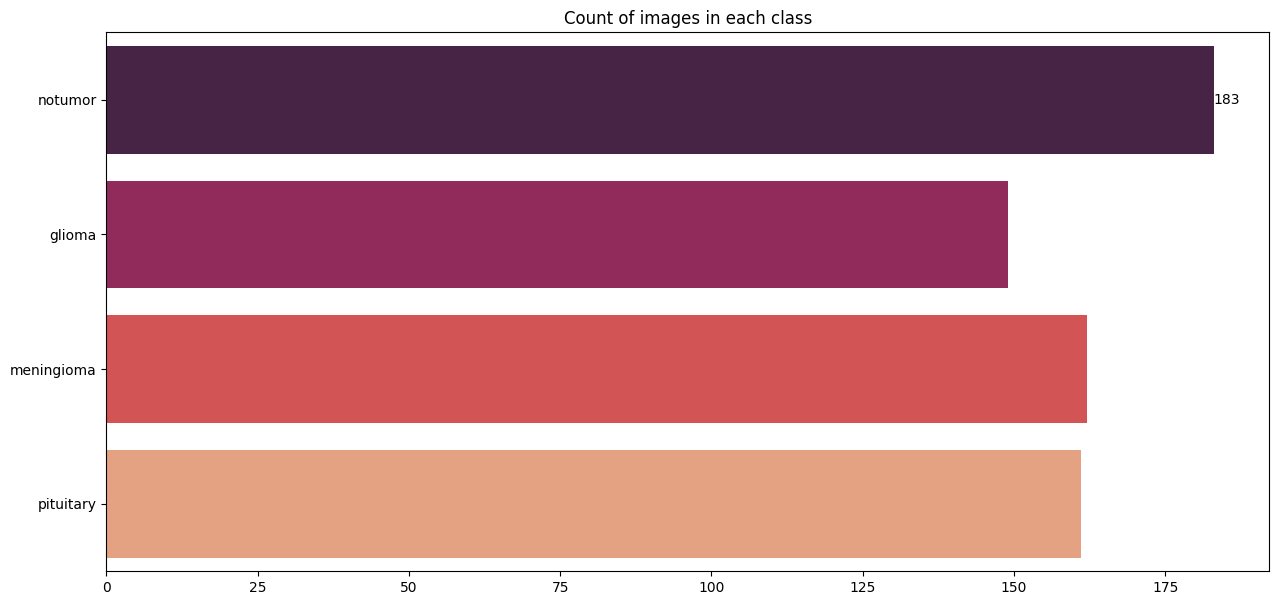

In [ ]:
count_images(valid_df)

# Data Preprocessing

In [ ]:
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=(0.8, 1.2)
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

Found 5842 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


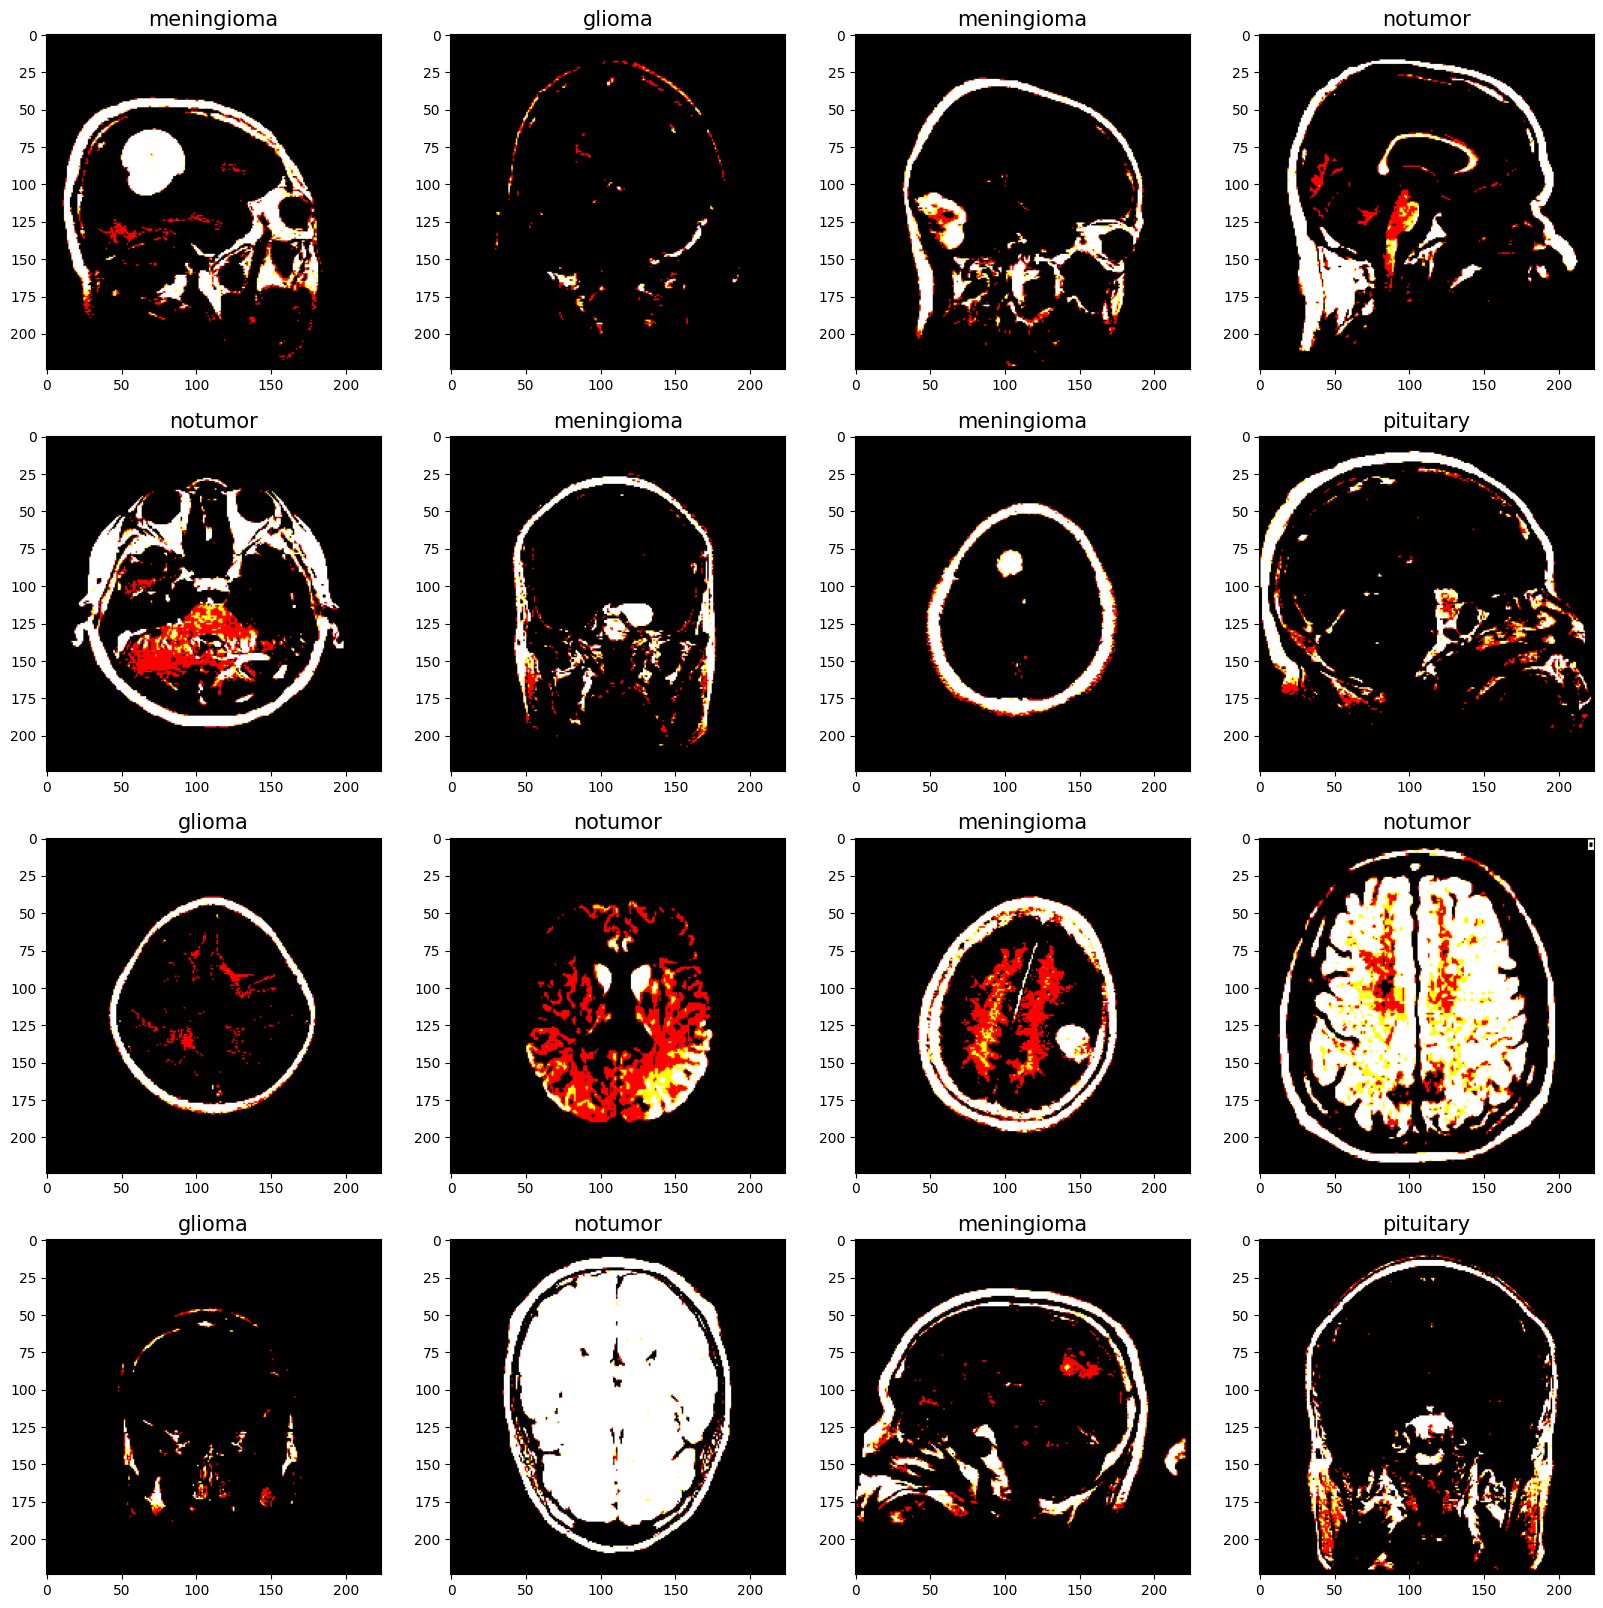

In [ ]:
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# Model Building

In [ ]:
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'
)

# froze all layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])



17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# base_model.summary()

# Model Training

In [ ]:
### Training Loop on GPU

with tf.device(device_name):
    # Training of top layer
    hist = model.fit(train_gen, validation_data=valid_gen, epochs=5)

Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.4917 - loss: 2.3366 - precision_6: 0.5111 - recall_6: 0.4648 - val_accuracy: 0.7298 - val_loss: 0.7572 - val_precision_6: 0.8638 - val_recall_6: 0.5130
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.6446 - loss: 0.8900 - precision_6: 0.7099 - recall_6: 0.5629 - val_accuracy: 0.7786 - val_loss: 0.6251 - val_precision_6: 0.8502 - val_recall_6: 0.6412
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.6925 - loss: 0.7737 - precision_6: 0.7490 - recall_6: 0.6174 - val_accuracy: 0.8015 - val_loss: 0.5286 - val_precision_6: 0.8603 - val_recall_6: 0.7145
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.7162 - loss: 0.7126 - precision_6: 0.7592 - recall_6: 0.6580 - val_accuracy: 0.8244 - val_loss: 0.5167 - val_precision_6: 0.8792 - val_recall_6: 0.7221
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.7508 - loss: 0.6293 - precision_6: 0.7928 - recall_6

In [ ]:
import time
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adamax(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.6801 - loss: 1.0055 - precision_7: 0.7097 - recall_7: 0.6486 - val_accuracy: 0.8366 - val_loss: 0.4537 - val_precision_7: 0.8673 - val_recall_7: 0.7985
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.7349 - loss: 0.6766 - precision_7: 0.7707 - recall_7: 0.6912 - val_accuracy: 0.8443 - val_loss: 0.4525 - val_precision_7: 0.8807 - val_recall_7: 0.7893
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.7611 - loss: 0.5918 - precision_7: 0.7976 - recall_7: 0.7197 - val_accuracy: 0.8473 - val_loss: 0.4282 - val_precision_7: 0.8773 - val_recall_7: 0.7969
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.7835 - loss: 0.5547 - precision_7: 0.8145 - recall_7: 0.7451 - val_accuracy: 0.8504 - val_loss: 0.4023 - val_precision_7: 0.8814 - val_recall_7: 0.8168
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.7863 - loss: 0.5393 - precision_7: 0.8171 - recall_7

In [ ]:
# # "defroze" some convolutional blocks
# # defroze last block of VGG16
# for layer in base_model.layers[-4:]:
#     layer.trainable = True

# model.compile(optimizer=Adamax(learning_rate=1e-4),  # lower LR for Fine-Tuning
#               loss='categorical_crossentropy',
#               metrics=['accuracy', Precision(), Recall()])

# with tf.device(device_name):
#     hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Model Testing

In [ ]:
hist = hist2

# Hist first phase

In [ ]:
# #tr_acc = hist.history['accuracy']
# #tr_loss = hist.history['loss']
# #tr_per = hist.history['precision_1']
# #tr_recall = hist.history['recall_1']
# #val_acc = hist.history['val_accuracy_1']
# #val_loss = hist.history['val_loss_1']
# #val_per = hist.history['val_precision_1']
# #val_recall = hist.history['val_recall_1']

# ####
# tr_acc = hist.history['accuracy']
# tr_loss = hist.history['loss']
# tr_per = hist.history['precision_1']
# tr_recall = hist.history['recall_1']
# val_acc = hist.history['val_accuracy']
# val_loss = hist.history['val_loss']
# val_per = hist.history['val_precision_1']
# val_recall = hist.history['val_recall_1']
# ####

# index_loss = np.argmin(val_loss)
# val_lowest = val_loss[index_loss]
# index_acc = np.argmax(val_acc)
# acc_highest = val_acc[index_acc]
# index_precision = np.argmax(val_per)
# per_highest = val_per[index_precision]
# index_recall = np.argmax(val_recall)
# recall_highest = val_recall[index_recall]

# Epochs = [i + 1 for i in range(len(tr_acc))]
# loss_label = f'Best epoch = {str(index_loss + 1)}'
# acc_label = f'Best epoch = {str(index_acc + 1)}'
# per_label = f'Best epoch = {str(index_precision + 1)}'
# recall_label = f'Best epoch = {str(index_recall + 1)}'


# plt.figure(figsize=(20, 12))
# plt.style.use('fivethirtyeight')
# plt.subplot(2, 2, 1)
# plt.plot(Epochs, tr_loss, 'r', label='Training loss')
# plt.plot(Epochs, val_loss, 'g', label='Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
# plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 3)
# plt.plot(Epochs, tr_per, 'r', label='Precision')
# plt.plot(Epochs, val_per, 'g', label='Validation Precision')
# plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
# plt.title('Precision and Validation Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 4)
# plt.plot(Epochs, tr_recall, 'r', label='Recall')
# plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
# plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
# plt.title('Recall and Validation Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()
# plt.grid(True)

# plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
# plt.show()

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
#Adamax

183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.8783 - loss: 0.3516 - precision_7: 0.9070 - recall_7: 0.8368
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8236 - loss: 0.4373 - precision_7: 0.8732 - recall_7: 0.7806
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8755 - loss: 0.3694 - precision_7: 0.8915 - recall_7: 0.8325
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
Train Loss: 0.3575
Train Accuracy: 87.26%
Train F1 Score: 0.2560
--------------------
Validation Loss: 0.3883
Validation Accuracy: 85.50%
Validation F1 Score: 0.2405
--------------------
Test Loss: 0.3642
Test Accuracy: 88.41%
Test F1 Score: 0.8832


In [ ]:
#add

In [ ]:
### Training Loop on GPU

# with tf.device(device_name):
#     # Training of top layer
#     hist = model.fit(train_gen, validation_data=valid_gen, epochs=5)

In [ ]:

from tensorflow.keras.optimizers import SGD

In [ ]:
import time
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=SGD(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.7937 - loss: 0.5107 - precision_8: 0.8279 - recall_8: 0.7590 - val_accuracy: 0.8611 - val_loss: 0.3840 - val_precision_8: 0.8907 - val_recall_8: 0.8214
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.7953 - loss: 0.5183 - precision_8: 0.8320 - recall_8: 0.7570 - val_accuracy: 0.8611 - val_loss: 0.3833 - val_precision_8: 0.8878 - val_recall_8: 0.8214
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.8032 - loss: 0.5117 - precision_8: 0.8310 - recall_8: 0.7647 - val_accuracy: 0.8611 - val_loss: 0.3823 - val_precision_8: 0.8876 - val_recall_8: 0.8198
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.7984 - loss: 0.5029 - precision_8: 0.8299 - recall_8: 0.7620 - val_accuracy: 0.8595 - val_loss: 0.3817 - val_precision_8: 0.8861 - val_recall_8: 0.8198
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.7973 - loss: 0.5257 - precision_8: 0.8259 - recall_8

In [ ]:
hist = hist2

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")

# SGD

183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.8826 - loss: 0.3433 - precision_8: 0.9085 - recall_8: 0.8442
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8846 - loss: 0.3590 - precision_8: 0.9031 - recall_8: 0.8469
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8670 - loss: 0.3597 - precision_8: 0.8821 - recall_8: 0.8304
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Train Loss: 0.3459
Train Accuracy: 87.88%
Train F1 Score: 0.2586
--------------------
Validation Loss: 0.3810
Validation Accuracy: 86.11%
Validation F1 Score: 0.2211
--------------------
Test Loss: 0.3543
Test Accuracy: 87.80%
Test F1 Score: 0.8767


In [ ]:
from tensorflow.keras.optimizers import AdamW

In [ ]:
hist = hist2

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
import time
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=AdamW(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.8060 - loss: 0.4975 - precision_9: 0.8300 - recall_9: 0.7778 - val_accuracy: 0.8611 - val_loss: 0.3591 - val_precision_9: 0.8922 - val_recall_9: 0.8214
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.8334 - loss: 0.4310 - precision_9: 0.8527 - recall_9: 0.8091 - val_accuracy: 0.8840 - val_loss: 0.2993 - val_precision_9: 0.9011 - val_recall_9: 0.8626
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.8432 - loss: 0.4180 - precision_9: 0.8617 - recall_9: 0.8201 - val_accuracy: 0.8809 - val_loss: 0.2898 - val_precision_9: 0.8875 - val_recall_9: 0.8672
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.8540 - loss: 0.3689 - precision_9: 0.8721 - recall_9: 0.8387 - val_accuracy: 0.9130 - val_loss: 0.2524 - val_precision_9: 0.9245 - val_recall_9: 0.8977
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.8733 - loss: 0.3269 - precision_9: 0.8887 - recall_9

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")

# adamw

183/183 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.9295 - loss: 0.1958 - precision_9: 0.9366 - recall_9: 0.9202
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9252 - loss: 0.2472 - precision_9: 0.9260 - recall_9: 0.9098
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9026 - loss: 0.2730 - precision_9: 0.9101 - recall_9: 0.8960
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
Train Loss: 0.1981
Train Accuracy: 92.81%
Train F1 Score: 0.2389
--------------------
Validation Loss: 0.2456
Validation Accuracy: 91.30%
Validation F1 Score: 0.2495
--------------------
Test Loss: 0.2511
Test Accuracy: 91.16%
Test F1 Score: 0.9114


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.8860 - loss: 0.3014 - precision_10: 0.8937 - recall_10: 0.8749 - val_accuracy: 0.9130 - val_loss: 0.2326 - val_precision_10: 0.9266 - val_recall_10: 0.9053
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.8922 - loss: 0.2815 - precision_10: 0.9035 - recall_10: 0.8797 - val_accuracy: 0.9282 - val_loss: 0.2126 - val_precision_10: 0.9359 - val_recall_10: 0.9145
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9079 - loss: 0.2474 - precision_10: 0.9151 - recall_10: 0.8969 - val_accuracy: 0.9298 - val_loss: 0.1922 - val_precision_10: 0.9323 - val_recall_10: 0.9252
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.9112 - loss: 0.2280 - precision_10: 0.9193 - recall_10: 0.9044 - val_accuracy: 0.9282 - val_loss: 0.1903 - val_precision_10: 0.9337 - val_recall_10: 0.9252
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9085 - loss: 0.2387 - precision_10: 

In [ ]:
hist = hist2

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
# adam

183/183 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9559 - loss: 0.1227 - precision_10: 0.9608 - recall_10: 0.9507
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9425 - loss: 0.1574 - precision_10: 0.9472 - recall_10: 0.9395
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9105 - loss: 0.2049 - precision_10: 0.9124 - recall_10: 0.9077
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
Train Loss: 0.1200
Train Accuracy: 95.96%
Train F1 Score: 0.2572
--------------------
Validation Loss: 0.1632
Validation Accuracy: 93.74%
Validation F1 Score: 0.2424
--------------------
Test Loss: 0.1944
Test Accuracy: 92.07%
Test F1 Score: 0.9199


In [ ]:
#end...

In [ ]:
# train_score = model.evaluate(train_gen_copy, verbose=1)
# valid_score = model.evaluate(valid_gen_copy, verbose=1)
# test_score = model.evaluate(test_gen_copy, verbose=1)

# print(f"Train Loss: {train_score[0]:.4f}")
# print(f"Train Accuracy: {train_score[1]*100:.2f}%")
# print('-' * 20)
# print(f"Validation Loss: {valid_score[0]:.4f}")
# print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
# print('-' * 20)
# print(f"Test Loss: {test_score[0]:.4f}")
# print(f"Test Accuracy: {test_score[1]*100:.2f}%")

In [ ]:
# ResNet101
preds = model.predict(test_gen_copy)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


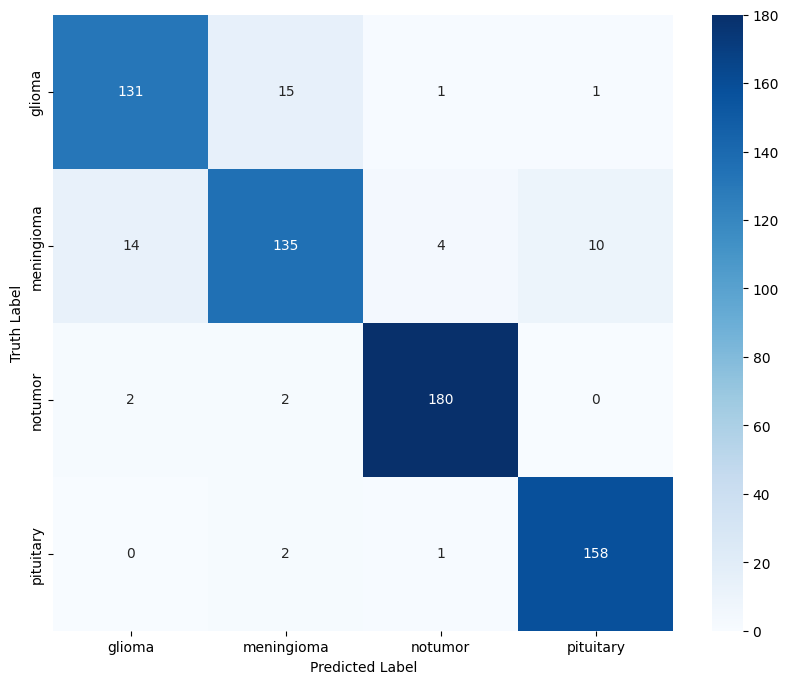

In [ ]:
### Confusion Matrix

cm = confusion_matrix(test_gen_copy.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
### Functin for getting predictions

def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()